<p style="text-align: center"><font size="7"> Projet MMSN 9 </font></p> 

<p style="text-align: center"><font size="7"> Trajectoire d'un satellite </font></p>

<figure>
    <img src="PageGarde.png" width="500">
</figure>

<p style="text-align: center"><font size="5"> Langolff Clément / Kessler Aymeric </font></p> 

## Introduction

L'objectif de ce projet et de modéliser la trajectoire d'un satellite en dimension trois. Pour cela, une première partie est dédiée à la recherche des équations régissants le satellite en coordonnées sphériques.   

Ensuite, nous implémenterons une méthode numérique pour simuler la trajectoire du satellite.   

Enfin, nous effecturons diffèrentes simulations et comparerons nos résultats avec une bibliothèque d'intégration de python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from tabulate import tabulate

import time

# Partie 1 théorie 

### Recherche de la dynamique

Dans ce projet, nous travaillons avec les dimensions suivantes :
* Longueur [L] en km
* Masse [M] en kg
* Temps [T] en secondes

Pour établir les équations diffèrentielles, il nous faut choisir des référentiels où celles-ci seront simples à exprimer.

Notons par $I_{T}=(O,X_{T},Y_{T},Z_{T})$ le repère cartésien
associé à la rotation de la Terre. 

<figure>
    <img src="repereTerre.png" width="375">
    <figcaption><Div Align=Center> Repère géocentrique $I_{t}$ </Div></figcaption>
</figure>

Ce repère tourne à une vitesse
angulaire $\varOmega_{T}$ correspondant à la vitesse de rotation de la Terre supposée constante. 
$$
\varOmega_{T}=\frac{2\pi}{jour\;sid\acute{e}rale\;(en\;sec)}=\frac{2\pi}{23,96\times3600}=7,295.10^{-5}\;rad/s
$$

Dans tous ce projet, on note mu le paramètre de gravitation lié à un système Terre-satellite.
$$
mu = G M_{T}
$$
où $G$ désigne la constante gravitationelle et $M_{T}$ la masse de la Terre exprimé en kilogrammes.

In [2]:
mu = 398600.4418   # G * Mt  en km³/ s²   

ms = 5.10e3        # masse satellite en kg

Soit $I_{S}=(O,X_{s},Y_{s},Z_{s})$ le repère sphérique associé au
repère $I_{T}$ qui resulte de la rotation positive de $\theta$ par
rapport à $Z_{T}$ et d'une rotation négative de $\varphi$ par rapport
à l'axe $Y_{S}$ tel que l'axe $x_{s}$ coïncide avec le vecteur position
noté $\boldsymbol{R}$. Ce repère suit la trajectoire du satellite.

<figure>
    <img src="repereSphere.png" width="350">
    <figcaption><Div Align=Center> Repère Sphérique $I_{S}$ </Div></figcaption>
</figure>

On peut alors exprimer le vecteur position dans le repère $I_{T}$:
$$
\boldsymbol{R}_{|I_{T}}=r\left(\begin{matrix}cos\varphi cos\theta\\
cos\varphi sin\theta\\
sin\varphi
\end{matrix}\right)
$$

et la vitesse angulaire de la Terre
$$
\boldsymbol{\varOmega}_{T|I_{T}}=\varOmega_{T}\left(\begin{matrix}0\\
0\\
1
\end{matrix}\right)
$$

On peut exprimer les matrice de passage du repère $I_{T}$ au repère
sphérique $I_{S}$ qui résulte du produit de deux matrices de rotation
; une première rotation suivant l'axe $Z_{T}$ de $\theta$ et une
deuxième matrice de rotation suivant l'axe $Y_{S}$

<img src="rotationtheta.png" width="350">
<img src="rotationphi.png" width="350">

Notons ce produit des deux matrices de rotation $M_{TS}$ permettant le passage du repère géocentrique au repère sphérique.

$$
\begin{align*}
M_{TS} & =M_{TS}^{\varphi}M_{TS}^{\theta}\\
 & =\left(\begin{matrix}cos\varphi & 0 & sin\varphi\\
0 & 1 & 0\\
-sin\varphi & 0 & cos\varphi
\end{matrix}\right)\left(\begin{matrix}cos\theta & sin\theta & 0\\
-sin\theta & cos\theta & 0\\
0 & 0 & 1
\end{matrix}\right)
\end{align*}
$$
$$
=\left(\begin{matrix}cos\varphi cos\theta & cos\varphi sin\theta & sin\varphi\\
-sin\theta & cos\theta & 0\\
-sin\varphi cos\theta & -sin\varphi sin\theta & cos\varphi
\end{matrix}\right)
$$

On retrouve bien évidemment  
$$
\begin{align*}
\boldsymbol{R}_{|I_{S}} & =M_{TS}\boldsymbol{R}_{|I_{T}}\\
 & =\left(\begin{matrix}cos\varphi cos\theta & cos\varphi sin\theta & sin\varphi\\
-sin\theta & cos\theta & 0\\
-sin\varphi cos\theta & -sin\varphi sin\theta & cos\varphi
\end{matrix}\right)r\left(\begin{matrix}cos\varphi sin\theta\\
cos\varphi cos\theta\\
sin\varphi
\end{matrix}\right)\\
 & =r\left(\begin{matrix}1\\
0\\
0
\end{matrix}\right)
\end{align*}
$$

L'expression de la vitesse angulaire de la Terre dans le repère sphérique est donnée par 
$$
\begin{align*}
\boldsymbol{\varOmega}_{T|I_{S}} & =M_{TS}\varOmega_{T}\left(\begin{matrix}0\\
0\\
1
\end{matrix}\right)\\
 & =\varOmega_{T}\left(\begin{matrix}sin\varphi\\
0\\
cos\varphi
\end{matrix}\right)
\end{align*}
$$

On note $\boldsymbol{\omega}_{|I_{S}}$ la vitesse angulaire du repère
$I_{S}$ par rapport au repère $I_{T}$.
$$
\boldsymbol{\omega}_{|I_{S}}=M_{TS}^{\varphi}\left[\begin{matrix}0\\
0\\
\dot{\theta}
\end{matrix}\right]+M_{TS}^{\theta}\left[\begin{matrix}0\\
-\dot{\varphi}\\
0
\end{matrix}\right]=\left[\begin{matrix}\dot{\theta}sin\varphi\\
-\dot{\varphi}\\
\dot{\theta}cos\varphi
\end{matrix}\right]
$$

On détermine ensuite l'accélération du mobile dans le repère $I_{S}$ avec le théorème du transport
[(wikipedia Transport theorem)](https://en.wikipedia.org/wiki/Transport_theorem) 

<br />
<br />


$$
\begin{align*}
\boldsymbol{A}_{|I_{S}} & =M_{TS}\boldsymbol{A}_{|I_{T}}\\
 & =M_{TS}\left(\frac{d\boldsymbol{V}_{|I_{T}}}{dt}+2\boldsymbol{\varOmega}_{T|I_{T}}\times\boldsymbol{V}_{|I_{T}}+\boldsymbol{\varOmega}_{T|I_{T}}\times(\boldsymbol{\varOmega}_{T|I_{T}}\times\boldsymbol{R}_{|I_{T}})\right)\\
 & =\underbrace{M_{TS}\frac{d\boldsymbol{V}_{|I_{T}}}{dt}}_{1}+\underbrace{2M_{TS}\boldsymbol{\varOmega}_{T|I_{T}}\times\boldsymbol{V}_{|I_{T}}}_{2}+\underbrace{M_{TS}\boldsymbol{\varOmega}_{T|I_{T}}\times(\boldsymbol{\varOmega}_{T|I_{T}}\times\boldsymbol{R}_{|I_{T}})}_{3})
\end{align*}
$$ 
* 1

$$
M_{TS}\frac{d\boldsymbol{V}_{|I_{T}}}{dt}=\frac{d\boldsymbol{V}_{|I_{S}}}{dt}+\boldsymbol{\omega}_{|I_{S}}\times\boldsymbol{V}_{|I_{S}}
$$

* 2
$$ 2M_{TS}\boldsymbol{\varOmega}_{T|I_{T}}\times\boldsymbol{V}_{|I_{T}}=2\boldsymbol{\varOmega}_{T|I_{S}}\times\boldsymbol{V}_{|I_{S}}
$$

* 3

$$
M_{TS}\boldsymbol{\varOmega}_{T|I_{T}}\times(\boldsymbol{\varOmega}_{T|I_{T}}\times\boldsymbol{R}_{|I_{T}})=\boldsymbol{\varOmega}_{T|I_{S}}\times(\boldsymbol{\varOmega}_{T|I_{S}}\times\boldsymbol{R}_{|I_{S}})
$$

<br />
<br />
Il nous faut déterminer les composantes de la vitesse dans le repère sphérique.
<br />

<br />

$$
\begin{align*}
\boldsymbol{V}_{|I_{S}} & =M_{TS}\frac{d\boldsymbol{R}_{|I_{T}}}{dt}\\
 & =\frac{d\boldsymbol{R}_{|I_{S}}}{dt}+\boldsymbol{\omega}_{|I_{S}}\times\boldsymbol{R}_{|I_{S}}\\
 & =\frac{dr}{dt}\left(\begin{matrix}1\\
0\\
0
\end{matrix}\right)+\left(\begin{matrix}0\\
r\dot{\theta}cos\varphi\\
r\dot{\varphi}
\end{matrix}\right)\\
 & =\left(\begin{matrix}\dot{r}\\
r\dot{\theta}cos\varphi\\
r\dot{\varphi}
\end{matrix}\right)
\end{align*}
$$

<br />
On calcule les éléments du premier terme
<br />
$$
\begin{align*}
\frac{d\boldsymbol{V}_{|I_{S}}}{dt} & =\frac{d^{2}r}{dt^{2}}\left(\begin{matrix}1\\
0\\
0
\end{matrix}\right)+\left(\begin{matrix}\dot{\theta}sin\varphi\\
-\dot{\varphi}\\
\dot{\theta}cos\varphi
\end{matrix}\right)\times\left(\begin{matrix}\dot{r}\\
r\dot{\theta}cos\varphi\\
r\dot{\varphi}
\end{matrix}\right)\\
 & =\left(\begin{matrix}\ddot{r}\\
r\ddot{\theta}cos\varphi+\dot{r}\dot{\theta}cos\varphi-r\dot{\varphi}\dot{\theta}sin\varphi\\
r\ddot{\varphi}+\dot{r}\dot{\varphi}
\end{matrix}\right)
\end{align*}
$$


$$
\begin{align*}
\boldsymbol{\omega}_{|I_{S}}\times\boldsymbol{V}_{|I_{S}} & =\left(\begin{matrix}\dot{\theta}sin\varphi\\
-\dot{\varphi}\\
\dot{\theta}cos\varphi
\end{matrix}\right)\times\left(\begin{matrix}\dot{r}\\
r\dot{\theta}cos\varphi\\
r\dot{\varphi}
\end{matrix}\right)\\
 & =\left(\begin{matrix}-r\dot{\varphi}-r\dot{\theta}^{2}cos^{2}\varphi\\
\dot{r}\dot{\theta}cos\varphi-r\dot{\varphi}\dot{\theta}sin\varphi\\
r\dot{\theta}^{2}cos\varphi sin\varphi+\dot{r}\dot{\varphi}
\end{matrix}\right)
\end{align*}
$$


<br />
<br />


Puis ceux du deuxième

$$
\begin{align*}
2\boldsymbol{\varOmega}_{T|I_{S}}\times\boldsymbol{V}_{|I_{S}} & =2\varOmega_{T}\left(\begin{matrix}sin\varphi\\
0\\
cos\varphi
\end{matrix}\right)\times\left(\begin{matrix}\dot{r}\\
r\dot{\theta}cos\varphi\\
r\dot{\varphi}
\end{matrix}\right)\\
 & =\left(\begin{matrix}-2r\varOmega_{T}\dot{\theta}cos{{}^2}\varphi\\
-2r\dot{\varphi}\varOmega_{T}sin\varphi+2\dot{r}\varOmega_{T}cos\varphi\\
2r\varOmega_{T}\dot{\theta}cos\varphi sin\varphi
\end{matrix}\right)
\end{align*}
$$


<br />
<br />

Et enfin, le troisième terme
$$
\begin{align*}
\boldsymbol{\varOmega}_{T|I_{S}}\times(\boldsymbol{\varOmega}_{T|I_{S}}\times\boldsymbol{R}_{|I_{S}}) & =\left(\begin{matrix}sin\varphi\\
0\\
cos\varphi
\end{matrix}\right)\times\left(\left(\begin{matrix}sin\varphi\\
0\\
cos\varphi
\end{matrix}\right)\times r\left(\begin{matrix}1\\
0\\
0
\end{matrix}\right)\right)\\
 & =\left(\begin{matrix}-2r\varOmega_{T}^{2}cos{{}^2}\varphi\\
0\\
r\varOmega_{T}^{2}cos\varphi sin\varphi
\end{matrix}\right)
\end{align*}
$$

<br />
<br />
En ajoutant tous les termes, nous obtenons l'expressions des composantes de l'accélération du mobile dans le repère sphérique

<br />
<br />

$$
\boldsymbol{A}_{|I_{S}}=\left(\begin{matrix}\ddot{r}-r\dot{\varphi}^{2}-rcos^{2}\varphi(\dot{\theta}+\varOmega_{T})^{2}\\
2(\dot{\theta}+\varOmega_{T})\left(\dot{r}cos\varphi-r\dot{\varphi}sin\varphi\right)+r\ddot{\theta}cos\varphi\\
2\dot{r}\dot{\varphi}+r\ddot{\varphi}+rcos\varphi sin\varphi(\varOmega_{T}+\dot{\theta})^{2}
\end{matrix}\right)
$$

On peut alors appliquer la deuxième loi de Newton dans le repère sphérique $I_{S}$, le mobile étant soumis seulement à la force de gravitation

$\boldsymbol{F_{g}}=-G\frac{M_{T}m_{S}}{r^{2}}\left[\begin{matrix}1\\
0\\
0
\end{matrix}\right]$

$$
\begin{cases}
\ddot{r} & =r\dot{\varphi}^{2}+rcos^{2}\varphi(\dot{\theta}+\varOmega_{T})^{2}-G\frac{M_{T}}{r^{2}}\\
\ddot{\theta} & =-2(\dot{\theta}+\varOmega_{T})\left(\frac{\dot{r}}{r}-\dot{\varphi}tan\varphi\right)\\
\ddot{\varphi} & =-2\frac{\dot{r}}{r}\dot{\varphi}-cos\varphi sin\varphi(\varOmega_{T}+\dot{\theta})^{2}
\end{cases}
$$

La vitesse de rotation de la Terre étant faible par rapport à la rotation du satellite, on néglige celle-ci.

$$
\begin{cases}
\ddot{r} & =r\dot{\varphi}^{2}+rcos^{2}\varphi\dot{\theta}^{2}-G\frac{M_{T}}{r^{2}}\\
\ddot{\theta} & =-2\dot{\theta}\left(\frac{\dot{r}}{r}-\dot{\varphi}tan\varphi\right)\\
\ddot{\varphi} & =-2\frac{\dot{r}}{r}\dot{\varphi}-cos\varphi sin\varphi\dot{\theta}^{2}
\end{cases}
$$

On transforme le système pour avoir une fonction de $\mathbb{R^{6}}→\mathbb{R^{6}}$ définie par 

$$
f:\left(\begin{matrix}r\\
\theta\\
\varphi\\
\dot{r}\\
\dot{\theta}\\
\dot{\varphi}
\end{matrix}\right)\rightarrow\left(\begin{matrix}\dot{r}\\
\dot{\theta}\\
\dot{\varphi}\\
r\dot{\varphi}^{2}+rcos^{2}\varphi\dot{\theta}^{2}-G\frac{M_{T}}{r^{2}}\\
-2\dot{\theta}\left(\frac{\dot{r}}{r}-\dot{\varphi}tan\varphi\right)\\
-2\frac{\dot{r}}{r}\dot{\varphi}-cos\varphi sin\varphi\dot{\theta}^{2}
\end{matrix}\right)
$$

In [3]:
def dynamique(Y,t):
    
    r, theta, phi, vr, vtheta, vphi = Y
    
    cp = np.cos(phi)
    vtheta2 = vtheta**2
    
    
    ar = r * (vphi**2 + cp**2 * vtheta2) - mu / r**2 
    atheta = - 2 * vtheta * (vr / r - vphi * np.tan(phi))
    aphi = - 2 * vr * vphi / r - cp * np.sin(phi) * vtheta2    

    return  np.array([vr,vtheta,vphi,ar,atheta,aphi])


### Conversion des paramètres sphériques dans le repère cartèsien

On sait que [(Wikipedia Spherical coordinate system)](https://en.wikipedia.org/wiki/Spherical_coordinate_system)
$$
\begin{align*}
r & =\sqrt{x{{}^2}+y{{}^2}+z{{}^2}}\\
\theta & =sign(y)arccos\left(\frac{x}{\sqrt{x{{}^2}+y{{}^2}}}\right)\\
\varphi & =arcsin\left(\frac{z}{r}\right)
\end{align*}
$$

en dérivant, nous trouvons
$$
\begin{align*}
\dot{r} & =\frac{x\dot{x}+y\dot{y}+z\dot{z}}{\sqrt{x{{}^2}+y{{}^2}+z{{}^2}}}\\
\dot{\theta} & =sign(y)\frac{\dot{x}y-x\dot{y}}{x^{2}+y{{}^2}}\\
\dot{\varphi} & =\frac{\dot{z}r-z\dot{r}}{r\sqrt{r{{}^2}-z{{}^2}}}
\end{align*}
$$

In [4]:
def XtoR(X,vX) :
    x,y,z = X
    vx,vy,vz = vX
    
    rxy = np.sqrt(x**2 + y**2)
    
    r = np.sqrt(x**2 + y**2 + z**2)
    theta =  np.sign(y) * np.arccos(x / rxy) 
    phi = np.arcsin(z / r) 
    
    vr = (x * vx + y * vy + z * vz) / r
    vtheta = np.sign(y) * (vx * y - x * vy) / rxy**2
    vphi = (vz * r - z * vr) / (r*np.sqrt(r**2-z**2))
    
    
    return np.array([r,theta,phi]),np.array([vr,vtheta,vphi])

Inversement, on peut exprimer les coordonnées du repère cartésien en fonction des coordonnées sphériques
$$
\begin{align*}
x & =rcos\varphi sin\theta\\
y & =rcos\varphi cos\theta\\
z & =rsin\varphi
\end{align*}
$$

et en dérivant 
$$
\begin{align*}
\dot{x} & =\dot{r}cos\varphi cos\theta-r\dot{\theta}cos\varphi sin\theta-r\dot{\varphi}cos\theta sin\varphi\\
\dot{y} & =\dot{r}cos\varphi cos\theta+r\dot{\theta}cos\varphi sin\theta-r\dot{\varphi}sin\theta sin\varphi\\
\dot{z} & =\dot{r}sin\varphi+r\dot{\varphi}cos\varphi
\end{align*}
$$

In [5]:
def RtoX(R,vR):
    r,theta,phi = R
    vr,vtheta,vphi = vR
    
    ct = np.cos(theta)
    cp = np.cos(phi)
    
    st = np.sin(theta)
    sp = np.sin(phi)    
    
    x = r * ct * cp 
    y = r * st * cp
    z = r * sp
    
    vx = vr*ct*cp-r*vtheta*st*cp-r*vphi*ct*sp 
    vy = vr*st*cp+r*vtheta*ct*cp-r*vphi*st*sp
    vz = vr*sp + r*vphi*cp
    
    return np.array([x,y,z]), np.array([vx,vy,vz])

## Méthode de simulation

Dans ce projet, nous souhaitons comparer les méthodes d'Euler Explicite et de Runge Kutta pour la résolution du mouvement du satellite.

#### fonction d'Euler Explicite

In [6]:
def euler_explicite(f, Y0, t):
        d = len(Y0)
        n = len(t)
        Y = np.zeros((d,n))
        Y[:,0] = Y0
        dt = t[1] - t[0]
        
        for i in range(n-1):
            Y[:,i+1] = Y[:,i] + dt * f(Y[:,i],t[i])
            
        return Y

#### fonction de Runge Kutta 4

In [7]:
def RK4(f, Y0, t) : 
   
    d = len(Y0)
    n = len(t)
    Y = np.zeros((d,n))
    Y[:,0] = Y0
    dt = t[1] - t[0] 
    dt_div2 = 0.5 * dt
    dt_div6 = dt / 6
    for i in range(n-1) :
        K1 = f(Y[:,i], t[i])
        K2 = f(Y[:,i] + dt_div2 * K1, t[i] + dt_div2)
        K3 = f(Y[:,i] + dt_div2 * K2, t[i] + dt_div2)
        K4 = f(Y[:,i] + dt * K3, t[i] + dt)
        
        Y[:,i+1] = Y[:,i] + dt_div6 * (K1 + 2 * K2 + 2 * K3 + K4)
        
    return Y

#### calcul des paramètres de la trajectoire

Pour se donner une idée de l'allure de la trajectoire, nous implementons une fonction permettant de trouver les paramètres de la trajectoire suivant la position et la vitesse initiale exprimées dans le repère géocentrique.
Cette fonction nous permet surtout de déterminer la période $T$ de la trajectoire qui va nous permettre d'integrer sur un intervalle de temps qui correspond exactement à un tour complet autour de la Terre.
Les raisonnements pour déterminer ces paramètres n'ont pas été développés, l'intégralité de leurs développements est disponible dans l'ouvrage "Orbital mechanics for engineering students" de Howard Curtis (Page 158).

<img src="paramTrajectoire.png" width="450">

In [8]:
def param(R,V,mu):
    
    I = np.array([1,0,0])
    J = np.array([0,1,0])
    K = np.array([0,0,1])
    
    r = np.linalg.norm(R)
    v = np.linalg.norm(V)
    vr = np.dot(R,V) / r
    
    H = np.cross(R,V)
    h = np.linalg.norm(H)
    
    i = np.arccos(H[2] / h)
    
    N = np.cross(K,H)
    n = np.linalg.norm(N)
    
    if (N[2] >= 0) :
        omega = np.arccos(N[0]/n)
    else : 
        omega = 360 - np.arccos(N[0]/n)
        
    E = ((v**2-mu/r)*R-r*vr*V) / mu
    e = np.linalg.norm(E)
    
    if (E[2] >= 0) :
        w = np.arccos(np.dot(N,E) / (n*e))
    else :
        w = 360 - np.arccos(np.dot(N,E) / (n*e))
        
    if (vr >= 0) : 
        theta = np.arccos((h**2/(mu*r) - 1) / e)
    else : 
        theta = 360 - np.arccos((h**2/(mu*r) - 1) / e)
    
    return h,e,i*180/np.pi,omega*180/np.pi,w*180/np.pi,theta*180/np.pi

# Partie 2 Simulations

Pour commencer nos simulations, nous reprenons les conditions initiales d'un exemple de l'ouvrage d'Howard Curtis (Page 184) pour vérifier notre implémentation.

#### Conditions initiales

$$
\begin{cases}
X_{0|I_{T}} & =\left(\begin{matrix}-3670\\
-3870\\
4400
\end{matrix}\right)\\
VX_{0|I_{T}} & =\left(\begin{matrix}4,7\\
-7,4\\
1
\end{matrix}\right)
\end{cases}
$$

In [9]:
X0 = np.array([-3670,-3870,4400])
VX0 = np.array([4.7,-7.4,1])
R0,VR0 = XtoR(X0,VX0)

r0,theta0,phi0 = R0
vr0,vtheta0,vphi0 = VR0

Y0 = np.array([r0,theta0,phi0,vr0,vtheta0,vphi0])

On recherche ensuite les paramètres spécifiques à cette trajectoire.

In [10]:
h,e,i,omega,w,theta11 = param(X0,VX0,mu)

vit  = np.linalg.norm(VX0)

rp = h**2 / (mu*(1 + e * np.cos(0)))
ra = h**2 / (mu*(1 + e * np.cos(180 * np.pi /180)))
a =(ra  + rp) / 2   
T = 2* np.pi * a**(3/2) / np.sqrt(mu)    

resHC = np.array([6914,8.823,58930,0.42607,39.687,130.32,42.373,52.404,15178,6109,10640,10928])


titreY = np.array(["rayon r (km)","vitesse v (km)","moment angulaire (constant) (km²/s)"
                   ,"exentricité e","inclinaison i (deg)","position angulaire noeud ascendant \u03A9 (deg)",
                   "argument de périgée \u03C9 (deg)","angle d'anomalie \u0398 (deg)","rayon apogée ra (km)",
                   "rayon périgée rp (km)","axe semi majeur a (km)","période T (sec)"])

titreX = np.array(["/","Simulation","Résultat de Howard Curtis"])

donnée = np.array([r0,vit,h,e,i,omega,w,theta11,ra,rp,a,T])
res = np.array([titreY,donnée,resHC]).T
res = np.concatenate(([titreX],res))
print(tabulate(res,tablefmt='fancy_grid'))

╒════════════════════════════════════════════╤════════════════════╤═══════════════════════════╕
│ /                                          │ Simulation         │ Résultat de Howard Curtis │
├────────────────────────────────────────────┼────────────────────┼───────────────────────────┤
│ rayon r (km)                               │ 6914.173847973451  │ 6914.0                    │
├────────────────────────────────────────────┼────────────────────┼───────────────────────────┤
│ vitesse v (km)                             │ 8.823264701911645  │ 8.823                     │
├────────────────────────────────────────────┼────────────────────┼───────────────────────────┤
│ moment angulaire (constant) (km²/s)        │ 58926.98031462328  │ 58930.0                   │
├────────────────────────────────────────────┼────────────────────┼───────────────────────────┤
│ exentricité e                              │ 0.4260716897917769 │ 0.42607                   │
├───────────────────────────────────────

## calcul de la solution et récupération des coordonnées

On commence notre simulation avec un pas de $\frac{T}{N}$ avec $N = 5000$ . Pour distinguer l'efficacité des méthodes, nous calculons leur temps d'exécution.

In [11]:
N = 5000
temps = np.linspace(0,T,N)

tps1 = time.time()
EE = euler_explicite(dynamique,Y0,temps)
tps2 = time.time()
tpsExecEE = tps2 - tps1


tps1 = time.time()
rk4 = RK4(dynamique,Y0,temps)
tps2 = time.time()
tpsExecRK4 = tps2 - tps1


tps1 = time.time()
solPython = odeint(dynamique,Y0,temps)
tps2 = time.time()
tpsExecSolPython = tps2 - tps1

In [12]:
# récupération des composantes
rEE = EE[0,:]
rrk4 = rk4[0,:]
rsolPython = solPython[:,0]

thetaEE = EE[1,:]
thetark4 = rk4[1,:]
thetasolPython = solPython[:,1]

phiEE = EE[2,:]
phirk4 = rk4[2,:]
phisolPython = solPython[:,2]

vrEE = EE[3,:]
vrrk4 = rk4[3,:]
vrsolPython = solPython[:,3]

vthetaEE = EE[4,:]
vthetark4 = rk4[4,:]
vthetasolPython = solPython[:,4]

vphiEE = EE[5,:]
vphirk4 = rk4[5,:]
vphisolPython = solPython[:,5]

On transforme les coordonnées sphériques dans le repère cartésien 

In [13]:
XEE,VXEE = RtoX(np.array([rEE,thetaEE,phiEE]),np.array([vrEE,vthetaEE,vphiEE]))

Xrk4,VXrk4 = RtoX(np.array([rrk4,thetark4,phirk4]),np.array([vrrk4,vthetark4,vphirk4]))

XsolPython,VXsolPython = RtoX(np.array([rsolPython,thetasolPython,phisolPython]),
                              np.array([vrsolPython,vthetasolPython,vphisolPython]))

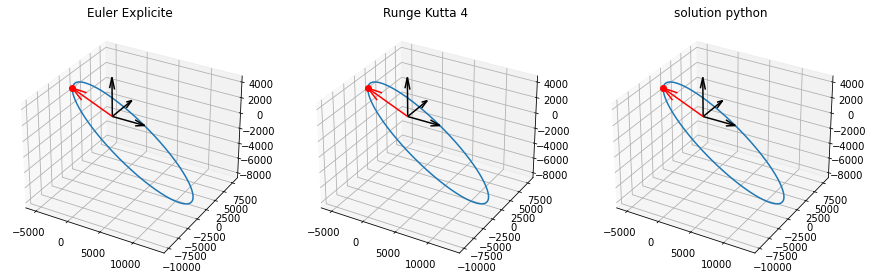

In [14]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(1,3,1,projection='3d')

ax1.plot(XEE[0,:],XEE[1,:],XEE[2,:])
ax1.plot(XEE[0,0],XEE[1,0],XEE[2,0],'ro')

ax1.quiver(0,0,0,XEE[0,0],XEE[1,0],XEE[2,0],color='r')
ax1.quiver(0,0,0,5000,0,0,color='black')
ax1.quiver(0,0,0,0,5000,0,color='black')
ax1.quiver(0,0,0,0,0,5000,color='black')
ax1.set_title("Euler Explicite")
ax2 = fig.add_subplot(1,3,2,projection='3d')

ax2.plot(Xrk4[0,:],Xrk4[1,:],Xrk4[2,:])
ax2.plot(Xrk4[0,0],Xrk4[1,0],Xrk4[2,0],'ro')

ax2.quiver(0,0,0,Xrk4[0,0],Xrk4[1,0],Xrk4[2,0],color='r')
ax2.quiver(0,0,0,5000,0,0,color='black')
ax2.quiver(0,0,0,0,5000,0,color='black')
ax2.quiver(0,0,0,0,0,5000,color='black')
ax2.set_title("Runge Kutta 4")

ax3 = fig.add_subplot(1,3,3,projection='3d')

ax3.plot(XsolPython[0,:],XsolPython[1,:],XsolPython[2,:])
ax3.plot(XsolPython[0,0],XsolPython[1,0],XsolPython[2,0],'ro')

ax3.quiver(0,0,0,XsolPython[0,0],XsolPython[1,0],XsolPython[2,0],color='r')
ax3.quiver(0,0,0,5000,0,0,color='black')
ax3.quiver(0,0,0,0,5000,0,color='black')
ax3.quiver(0,0,0,0,0,5000,color='black')
ax3.set_title("solution python")

plt.show()

Étant donné que l'on calcule nos trajectoires sur une période équivalente à un tour complet, nous allons évaluer l'erreur de chaque méthode en calculant la distance entre le dernier point calculé et le point initial.

In [15]:
errDistEE = np.linalg.norm(X0-XEE[:,-1])
errDistrk4 = np.linalg.norm(X0-Xrk4[:,-1])
errDistSolPython = np.linalg.norm(X0-XsolPython[:,-1])


tabErr = np.array(["erreur en mètre",errDistEE,errDistrk4,errDistSolPython])
tabTpsExec = np.array(["temps d'exécution",tpsExecEE,tpsExecRK4,tpsExecSolPython])
titre = np.array(["/","Euler EXplicite","Runge Kutta 4","solution Python"])
print(tabulate(([titre,tabErr,tabTpsExec]),tablefmt='fancy_grid'))

╒═══════════════════╤═════════════════════╤══════════════════════╤══════════════════════╕
│ /                 │ Euler EXplicite     │ Runge Kutta 4        │ solution Python      │
├───────────────────┼─────────────────────┼──────────────────────┼──────────────────────┤
│ erreur en mètre   │ 407.643685769243    │ 7.71403550795853e-08 │ 0.031239497932548935 │
├───────────────────┼─────────────────────┼──────────────────────┼──────────────────────┤
│ temps d'exécution │ 0.31121182441711426 │ 1.1629483699798584   │ 0.023441791534423828 │
╘═══════════════════╧═════════════════════╧══════════════════════╧══════════════════════╛


L'erreur de distance n'est peut être pas visible dans les graphes entre les diffèrentes méthodes mais elle est clairement distinguable dans le tableau ci-dessus.
Sans Surprise, la méthode d'Euler Explicite est la moins précise mais on peut noter qu'elle ne s'en sort pas trop mal en comparaison de la dimension des distances (407 mètres à comparer avec le rayon de périgée de l'ordre de 6000km).
<br />
Les méthodes de Runge-Kutta et de la librairie python sont en revanche extrêmement précises, de l'ordre du nanomètre pour la méthode rk4 et au centimètre près pour la librairie python. Cependant, il est intéressant de noter  que la méthode utilisée par python est 100 fois plus rapide à l'exécution. La méthode utilisée par la fonction odeint provient de la fonction lsoda codée en FORTRAN qui utilise la méthode d'Adam ou de Gears suivant la stabilité du problème.

### Analyse de l'erreur

Pour tester la précision numérique des méthodes, nous effectuons plusieurs tests en changeant le nombre de pas.

In [16]:
def calculErreur(listN,Y0) :
    
    h,e,i,omega,w,theta11 = param(X0,VX0,mu)
    rp = h**2 / (mu*(1 + e * np.cos(0)))
    ra = h**2 / (mu*(1 + e * np.cos(180 * np.pi /180)))
    a =(ra  + rp) / 2
    T = 2* np.pi * a**(3/2) / np.sqrt(mu)
    tabTpsExec = np.zeros((len(listN),3))
    tabErreur =  np.zeros((len(listN),3))
    i = 0    
    for N in (listN) :
        temps = np.linspace(0,T,N)
        
        # calcul des solutions
        tps1 = time.time()
        EE = euler_explicite(dynamique,Y0,temps)
        tps2 = time.time()
        tpsExecEE = tps2 - tps1

        tps1 = time.time()
        rk4 = RK4(dynamique,Y0,temps)
        tps2 = time.time()
        tpsExecRK4 = tps2 - tps1

        tps1 = time.time()
        solPython = odeint(dynamique,Y0,temps)
        tps2 = time.time()
        tpsExecSolPython = tps2 - tps1

        tabTpsExec[i,:] = tpsExecEE,tpsExecRK4,tpsExecSolPython
        
        #recupération du dernier point pour chaques méthodes
        XEE,VXEE = RtoX(np.array([EE[0,-1],EE[1,-1],EE[2,-1]]),np.array([EE[3,-1],EE[4,-1],EE[5,-1]]))
        Xrk4,VXrk4 = RtoX(np.array([rk4[0,-1],rk4[1,-1],rk4[2,-1]]),np.array([rk4[3,-1],rk4[4,-1],rk4[5,-1]]))
        XsolPython,VXsolPython = RtoX(np.array([solPython[-1,0],solPython[-1,1],solPython[-1,2]]),
                              np.array([solPython[-1,3],solPython[-1,4],solPython[-1,5]]))
        
        #calcul de l'erreur
        errDistEE = np.linalg.norm(X0-XEE)
        errDistrk4 = np.linalg.norm(X0-Xrk4)
        errDistSolPython = np.linalg.norm(X0-XsolPython)
        
        tabErreur[i,:] = errDistEE,errDistrk4,errDistSolPython
        
        i+=1
        
    return tabErreur,tabTpsExec

#### calcul des solutions pour diffèrents N

In [17]:
X0 = np.array([-3670,-3870,4400])
VX0 = np.array([4.7,-7.4,1])
R0,VR0 = XtoR(X0,VX0)

r0,theta0,phi0 = R0
vr0,vtheta0,vphi0 = VR0

Y0 = np.array([r0,theta0,phi0,vr0,vtheta0,vphi0])
listN = (500,1000)

# récupération des erreurs et du temps d'exécution
tabErr,tabTps = calculErreur(listN,Y0)

In [18]:
titreErr = ("N","errEE","errRK4","errSolPython")
titreTps = ("N","temps EE","temps RK4","temps SolPython")

tabErr = np.concatenate(([listN],tabErr.T))
tabTps = np.concatenate(([listN],tabTps.T))

print(tabulate(np.concatenate(([titreErr],tabErr.T)),tablefmt='fancy_grid'))
print(tabulate(np.concatenate(([titreTps],tabTps.T)),tablefmt='fancy_grid'))

╒════════╤════════════════════╤════════════════════════╤═════════════════════╕
│ N      │ errEE              │ errRK4                 │ errSolPython        │
├────────┼────────────────────┼────────────────────────┼─────────────────────┤
│ 500.0  │ 3895.465418834584  │ 0.000534381313921392   │ 0.07215232881833882 │
├────────┼────────────────────┼────────────────────────┼─────────────────────┤
│ 1000.0 │ 1999.5934635538908 │ 4.1425295505037226e-05 │ 0.03496322866861213 │
╘════════╧════════════════════╧════════════════════════╧═════════════════════╛
╒════════╤═════════════════════╤═════════════════════╤══════════════════════╕
│ N      │ temps EE            │ temps RK4           │ temps SolPython      │
├────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ 500.0  │ 0.03168296813964844 │ 0.1276836395263672  │ 0.023282766342163086 │
├────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ 1000.0 │ 0.0625307559967041  │ 0.21140694618225098 │ 0.

Nous pouvons remarquer que l'erreur de la méthode d'Euler Explicite est divisée par 2 lorsque l'on multiplie le nombre de pas par 2. Le temps, quand à lui, n'est pas doublé. En revanche, il est doublé pour la méthode de Runge Kutta 4. Étonnemment, il diminue pour la méthode de la librairie Python. 

Voici un capture d'écran pour un pas doublé jusqu'à une valeur de 64000. 

<img src="ErrNdifferent64000.png" width="600">

L'erreur faite par la méthode d'Euler Explicite est bien divisée par 2 à chaques fois. Paradoxalement, l'erreur de la méthode de la librairie Python ne fait que d'augmenter lorsque l'on augmente le pas. L'erreur de la méthode de Runge Kutta 4 à l'air de converger mais il n'y a aucun intêret à augmenter le nombre de pas puisque le temps d'exécution ne fait que de doubler pour une précision déjà excellente.

### Repère périfocale

Par la suite, nous souhaitons pouvoir éxercer plus de force sur le satellite que la force de gravitation. Une force de poussée moteur par exemple. Pour cela nous allons faciliter la tache en procédant à une projection de la trajectoire en 3 dimensions sur le plan parallèle à la trajectoire. Ce plan dispose d'un nouveau repère $P$ ($p_{x}$ et $p_{y}$) que l'on nomme repère périfocale.  
<b />

On utilise pour cela une matrice de rotation que l'on calcule grâce aux paramètres calculés précédéments.
On effectue d'abord une rotation suivant $\varOmega$,puis une rotation suivant l'inclinaison $i$ et on aligne les vecteurs unitaires avec le semi-axe majeur en effectuant une rotation de $\omega$. Nous obtenons alors comme matrice (ref Pages 174, Howard Curtis)

$$
Q_{P→T} = \left(\begin{matrix}cos(\varOmega)cos(\omega)-sin(\varOmega)sin(\omega)cos(i) & -cos(\varOmega)sin(\omega)-sin(\varOmega)cos(i)cos(\omega) & sin(\varOmega)sin(i)\\
sin(\varOmega)cos(\omega)+cos(\varOmega)sin(\omega)cos(i) & -sin(\varOmega)sin(\omega)+cos(\varOmega)cos(\omega)cos(i) & -cos(\varOmega)sin(i)\\
sin(i)sin(\omega) & sin(i)cos(\omega) & cos(i)
\end{matrix}\right)
$$

Puisque la matrice $Q$ est unitaire, on peut faire le retour du repère périfocale vers le repère terrestre en prenant sa transposé.  

In [19]:
def RotationMat(omega,i,w):   # en degrès
    i = i * np.pi / 180
    omega = omega * np.pi / 180
    w = w * np.pi / 180
    
    co = np.cos(omega)
    cw = np.cos(w)
    ci = np.cos(i)
    
    so = np.sin(omega)
    sw = np.sin(w)
    si = np.sin(i)
    
    Q11 =   co * cw - so * sw * ci
    Q12 = - co * sw - so * ci * cw
    Q13 =   so * si
    Q21 =   so * cw + co * ci * sw
    Q22 = - so * sw + co * ci * cw
    Q23 = - co * si
    Q31 =   si * sw
    Q32 =   si * cw
    Q33 =   ci
    
    Q = np.array([[Q11,Q12,Q13],
                  [Q21,Q22,Q23],
                  [Q31,Q32,Q33]])
    
    return Q  #Qp→T

In [20]:
Q = RotationMat(omega,i,w)

On effectue une projection de la solution calculée par la méthode d'Euler Explicite sur le plan périfocale.

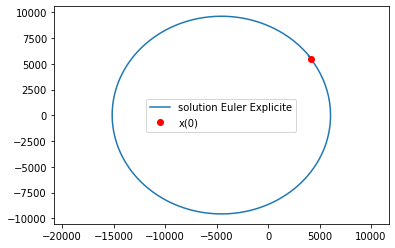

In [21]:
per = np.matmul(Q.T,XEE).T
plt.plot(per[:,0],per[:,1],label="solution Euler Explicite")
plt.plot(per[0,0],per[0,1],'ro',label="x(0)")
plt.axis('equal')
plt.legend()
plt.show()

Théoriquement, cette matrice annule la composante z pour chaques vecteurs calculés. On définit alors un nouveau type d'erreur en sommant la dernière composante de tous les vecteurs pour chaques méthodes.

In [22]:
# projection sur le plan orbital
perEE = np.matmul(Q.T,XEE).T
perRK4 = np.matmul(Q.T,Xrk4).T
perSolPython = np.matmul(Q.T,XsolPython).T

In [23]:
# calcul de l'erreur
ErrPerEE = np.abs(np.sum(perEE[:,2]))
ErrPerRK4 = np.abs(np.sum(perRK4[:,2]))
ErrPerSolPython = np.abs(np.sum(perSolPython[:,2]))

In [24]:
tabErrPer = np.array([ErrPerEE,ErrPerRK4,ErrPerSolPython])
titre = ("erreur EE","erreur RK4","erreur sol Python")
print(tabulate([titre,tabErrPer],tablefmt='fancy_grid'))

╒═══════════════════╤═══════════════════════╤════════════════════╕
│ erreur EE         │ erreur RK4            │ erreur sol Python  │
├───────────────────┼───────────────────────┼────────────────────┤
│ 66638.81296558293 │ 2.849568226870325e-05 │ 12.248313436602475 │
╘═══════════════════╧═══════════════════════╧════════════════════╛


Nous tirons les mêmes conclusions que précédement, la méthode de Runge Kutta 4 est bien la plus précise, aux prix du coût de calcul.

Ci dessous, une visualisation interactive de la trajectoire pour chaques méthodes.

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'scene'}, {'type': 'scene'}],[{'type': 'scene'},{'type': 'scene'}]])


fig.add_trace(
    go.Scatter3d(x=XEE[0,:],y=XEE[1,:],z=XEE[2,:],marker=dict(size=1,color="red")),
    row=1, col=1)

fig.add_trace(
    go.Scatter3d(x=Xrk4[0,:],y=Xrk4[1,:],z=Xrk4[2,:],marker=dict(size=1,color="green")),
    row=1, col=2)

fig.add_trace(
    go.Scatter3d(x=XsolPython[0,:],y=XsolPython[1,:],z=XsolPython[2,:],marker=dict(size=1,color="green")),
    row=2, col=1)


fig.update_layout(
    title_text='Orbite avec les diffèrentes méthodes',
    height=1000,
    width=1000
)

## Simulation 2

On souhaite simuler la trajectoire du satellite sur une orbite géostationnaire. Pour cela nous devons trouver les bonnes conditions initiales. 
Être sur une orbite géostationnaire signifie rester à la même position au dessus de la Terre. Ainsi le satellite doit avoir une vitesse angulaire exactement égale à celle de la Terre, sa période vaut alors un jours.

In [26]:
Tgeo = 23.96 * 3600

La vitesse angulaire $\omega_{geo}$ est lié à la période par la formule 
$$
\omega_{geo} = \frac{2\pi}{T}
$$

In [27]:
wgeo = 2 * np.pi / Tgeo

On peut alors trouver l'altitude de l'orbite grâce à la 3ème loi de Kepler
$$
T = \frac{2\pi}{\sqrt{\mu}}r^{\frac{3}{2}}
$$
<br />
$$
r_{geo} = \left ( \frac{T_{geo}^{2}\mu}{4\pi^{2}} \right )^{\frac{1}{3}}=\left ( \frac{\mu}{\omega_{geo}^{2}} \right )^{\frac{1}{3}}
$$

In [28]:
rgeo = (mu / wgeo**2)**(1/3)

#### Conditions initiales

$$
\begin{cases}
X_{0|I_{S}} & =\left(\begin{matrix}r_{geo}\\
0\\
0
\end{matrix}\right)\\
VX_{0|I_{S}} & =\left(\begin{matrix}0\\
\omega_{geo}\\
0
\end{matrix}\right)
\end{cases}
$$

In [29]:
R0 = np.array([rgeo,0,0])
VR0 = np.array([0,wgeo,0])

In [30]:
X0,VX0 = RtoX(R0,VR0)

h,e,i,omega,w,theta11 = param(X0,VX0,mu)

vit  = np.linalg.norm(VX0)

rp = h**2 / (mu*(1 + e * np.cos(0)))
ra = h**2 / (mu*(1 + e * np.cos(180 * np.pi /180)))
a =(ra  + rp) / 2   #en km
T = 2* np.pi * a**(3/2) / np.sqrt(mu)    #en seconde

titreY = np.array(["rayon r (km)","vitesse v (km)","moment angulaire (constant) (km²/s)"
                   ,"exentricité e","inclinaison i (deg)","position angulaire noeud ascendant \u03A9 (deg)",
                   "argument de périgée \u03C9 (deg)","angle d'anomalie \u0398 (deg)","rayon apogée ra (km)",
                   "rayon périgée rp (km)","axe semi majeur a (km)","période T (sec)"])

donnée = np.array([r0,vit,h,e,i,omega,w,theta11,ra,rp,a,T])
res = np.array([titreY,donnée]).T
print(tabulate(res,tablefmt='fancy_grid'))

╒════════════════════════════════════════════╤═════════════════╕
│ rayon r (km)                               │   6914.17       │
├────────────────────────────────────────────┼─────────────────┤
│ vitesse v (km)                             │      3.07357    │
├────────────────────────────────────────────┼─────────────────┤
│ moment angulaire (constant) (km²/s)        │ 129687          │
├────────────────────────────────────────────┼─────────────────┤
│ exentricité e                              │      1.5043e-15 │
├────────────────────────────────────────────┼─────────────────┤
│ inclinaison i (deg)                        │      0          │
├────────────────────────────────────────────┼─────────────────┤
│ position angulaire noeud ascendant Ω (deg) │    nan          │
├────────────────────────────────────────────┼─────────────────┤
│ argument de périgée ω (deg)                │    nan          │
├────────────────────────────────────────────┼─────────────────┤
│ angle d'anomalie Θ (deg

/tmp/ipykernel_17671/445587266.py:20: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipykernel_17671/445587266.py:28: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipykernel_17671/445587266.py:33: RuntimeWarning:

invalid value encountered in arccos



On retrouve ici l'excentricité typique d'une orbite circulaire (e = 0) ainsi que la période de rotation de la Terre. Les conditions initiales étant posées pour que la trajectoire reste dans le plan équatoriale, la position angulaire du noeud ascendant, l'argument de périgé et l'angle d'anomalie n'ont plus de sens dans ce contexte, ils ne sont pas définis.

In [31]:
N = 5000
temps = np.linspace(0,T,N)
Y0 = np.array([R0[0],R0[1],R0[2],VR0[0],VR0[1],VR0[2]])

# calcul des solutions
tps1 = time.time()
EE = euler_explicite(dynamique,Y0,temps)
tps2 = time.time()
tpsExecEE = tps2 - tps1


tps1 = time.time()
rk4 = RK4(dynamique,Y0,temps)
tps2 = time.time()
tpsExecRK4 = tps2 - tps1


tps1 = time.time()
solPython = odeint(dynamique,Y0,temps)
tps2 = time.time()
tpsExecSolPython = tps2 - tps1

In [32]:
# récupération des composantes
rEE = EE[0,:]
rrk4 = rk4[0,:]
rsolPython = solPython[:,0]

thetaEE = EE[1,:]
thetark4 = rk4[1,:]
thetasolPython = solPython[:,1]

phiEE = EE[2,:]
phirk4 = rk4[2,:]
phisolPython = solPython[:,2]

vrEE = EE[3,:]
vrrk4 = rk4[3,:]
vrsolPython = solPython[:,3]

vthetaEE = EE[4,:]
vthetark4 = rk4[4,:]
vthetasolPython = solPython[:,4]

vphiEE = EE[5,:]
vphirk4 = rk4[5,:]
vphisolPython = solPython[:,5]

In [33]:
# conversion dans le repère géocentrique
XEE,VXEE = RtoX(np.array([rEE,thetaEE,phiEE]),np.array([vrEE,vthetaEE,vphiEE]))

Xrk4,VXrk4 = RtoX(np.array([rrk4,thetark4,phirk4]),np.array([vrrk4,vthetark4,vphirk4]))

XsolPython,VXsolPython = RtoX(np.array([rsolPython,thetasolPython,phisolPython]),
                              np.array([vrsolPython,vthetasolPython,vphisolPython]))

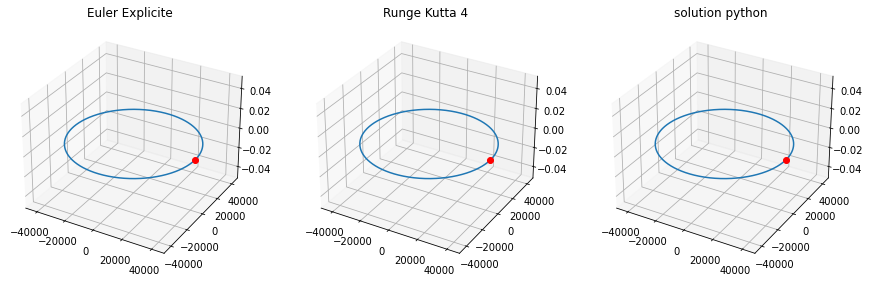

In [34]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(1,3,1,projection='3d')

ax1.plot(XEE[0,:],XEE[1,:],XEE[2,:])
ax1.plot(XEE[0,0],XEE[1,0],XEE[2,0],'ro')



ax1.set_title("Euler Explicite")
ax2 = fig.add_subplot(1,3,2,projection='3d')

ax2.plot(Xrk4[0,:],Xrk4[1,:],Xrk4[2,:])
ax2.plot(Xrk4[0,0],Xrk4[1,0],Xrk4[2,0],'ro')


ax2.set_title("Runge Kutta 4")

ax3 = fig.add_subplot(1,3,3,projection='3d')

ax3.plot(XsolPython[0,:],XsolPython[1,:],XsolPython[2,:])
ax3.plot(XsolPython[0,0],XsolPython[1,0],XsolPython[2,0],'ro')


ax3.set_title("solution python")

plt.show()

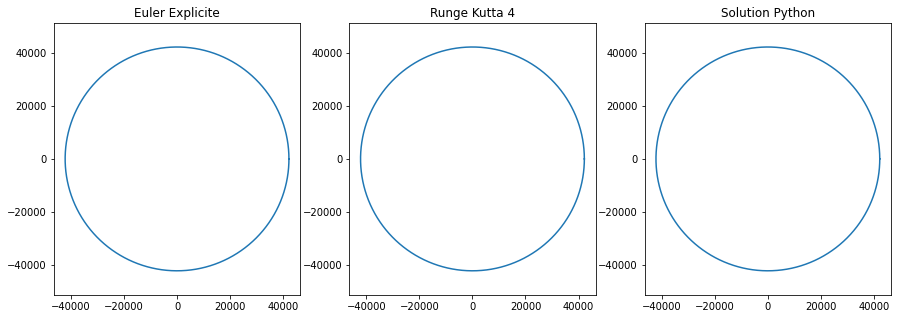

In [35]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)

ax1.axis('equal')
ax1.plot(XEE[0],XEE[1])
ax1.set_title("Euler Explicite")
ax2 = fig.add_subplot(1,3,2)
ax2.axis('equal')
ax2.plot(Xrk4[0],Xrk4[1])
ax2.set_title("Runge Kutta 4")

ax3 = fig.add_subplot(1,3,3)
ax3.axis('equal')
ax3.plot(XsolPython[0],XsolPython[1])
ax3.set_title("Solution Python")
plt.show()

Nos trajectoires sont bien circulaires, cherchons à calculer les erreurs sur cette orbite.

In [36]:
errDistEE = np.linalg.norm(X0-XEE[:,-1])
errDistrk4 = np.linalg.norm(X0-Xrk4[:,-1])
errDistSolPython = np.linalg.norm(X0-XsolPython[:,-1])


tabErr = np.array(["erreur en mètre",errDistEE,errDistrk4,errDistSolPython])
tabTpsExec = np.array(["temps d'exécution",tpsExecEE,tpsExecRK4,tpsExecSolPython])
titre = np.array(["/","Euler EXplicite","Runge Kutta 4","solution Python"])
print(tabulate(([titre,tabErr,tabTpsExec]),tablefmt='fancy_grid'))

╒═══════════════════╤═══════════════════════╤═══════════════════════╤═══════════════════════╕
│ /                 │ Euler EXplicite       │ Runge Kutta 4         │ solution Python       │
├───────────────────┼───────────────────────┼───────────────────────┼───────────────────────┤
│ erreur en mètre   │ 1.376274889411593e-09 │ 1.376274889411593e-09 │ 4.590292159301864e-07 │
├───────────────────┼───────────────────────┼───────────────────────┼───────────────────────┤
│ temps d'exécution │ 0.3372986316680908    │ 1.110645055770874     │ 0.0020923614501953125 │
╘═══════════════════╧═══════════════════════╧═══════════════════════╧═══════════════════════╛


Cette fois ci la méthode d'Euler Explicite est la plus précise ! La solution python reste cependant bien plus rapide même si on perd en précision. 

Grâce à la matrice de passage du repère périfocale vers le repère géocentrique, nous pouvons maintenant donner des inclinaisons à notre orbite géostationnaire. L'orbite étant circulaire, changer la valeur de l'argument du périgé $\omega$ n'aura aucune incidence. En revanche, nous pouvons changer l'inclinaison $i$ ainsi que la position du noeud ascendant $\varOmega$.

In [37]:
Q = RotationMat(-70,30,0)  # varOmega, i , w

On calcule les nouvelles composantes dans le repère géocentrique pour la solution de Runge Kutta 4.

In [38]:
InvPer = np.matmul(Q,Xrk4)

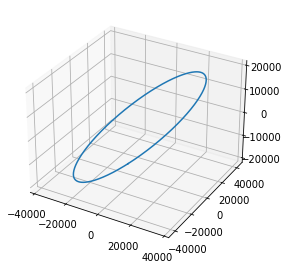

In [39]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(1,3,1,projection='3d')
ax1.plot(InvPer[0,:],InvPer[1,:],InvPer[2,:])
plt.show()

# Conclusion

Pour conclure, ce projet a été très intéressant puisqu'il a touché à diffèrents domaines d'étude comme la physique, les mathématiques et la programmation.   
Nous nous somme rendu compte que l'étude de trajectoire d'un satellite en 3 dimensions est bien plus compliquée que l'étude en 2 dimensions.  
Concernant l'étude numérique, nous nous sommes rendu compte qu'il n'y avait pas de bonne ou mauvaise méthode pour la résolution des équations diffèrentielles. Tout dépend du problème posé, des conditions initiales et surtout du niveau de précision éxigé. Cependant la méthode qui allie efficacité et précision pour le cadre de notre étude est la méthode implémenté par python.
<b /> 

Nous remercions Madame Zidani pour avoir proposé ce sujet à qui nous portons un grand interêt. 